In [11]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import shapefile
import matplotlib.dates as mdates
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline

##### 1. Define auxiliary functions (Maps based on https://chih-ling-hsu.github.io/about/)

In [16]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]

        if reg_name == 'EWR':  # Skip 'EWR'
            continue
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    ax.set_xticks([])
    ax.set_yticks([])
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())+1/1000,max(heat.values())+1/1000))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['shape_area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

##### Load Shapefile

In [17]:
# Read the shapefile
sf = shapefile.Reader("Data/Shapefiles/geo_export_7766f064-29c1-4e13-b2d9-2e368707ff51.shp")

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# look at shapefile and merge with longitude and latitude
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("location_i"), on="location_i")

#### Plot Boroughs and Taxi Zones

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


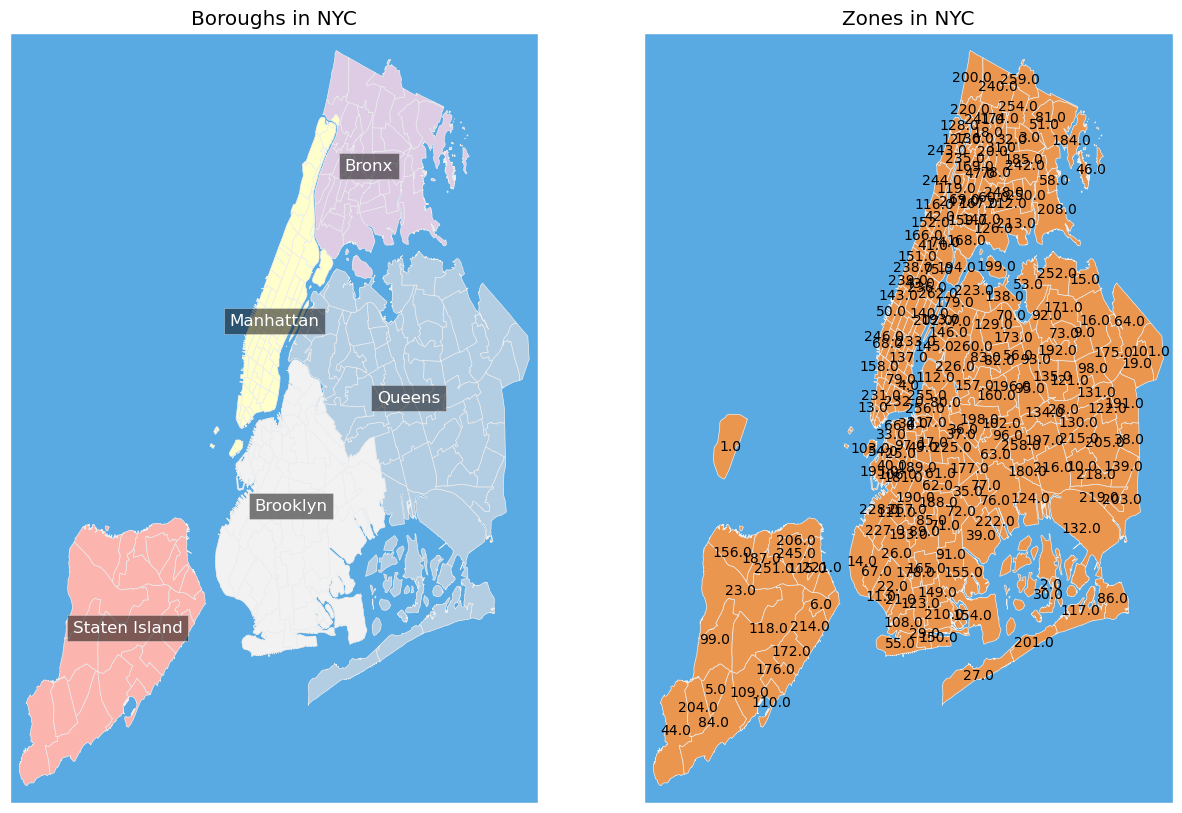

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

##### Trips per borough 2014-2019

1. Medallion Taxis (Yellow + Green Cabs)
2. For-Hire-Vehicles

In [20]:
yellow = pd.read_csv('Data/Pooled_data/PU/final/final_data_YG_PU.csv')
# exclude where year-fact is one
yellow = yellow[yellow['Year_fact'] != 1]
fhv = pd.read_csv('Data/Pooled_data/PU/final/final_data_FHV_PU.csv')
# sum the variable trip_number grouped by PULocationID
yellow_pickup = yellow.groupby("PULocationID").agg({"trip_number": "sum"}).reset_index()
fhv_pickup = fhv.groupby("PULocationID").agg({"trip_number": "sum"}).reset_index()
# add column "borough" to green_pickup by using variables borough and location_id from df_loc only keeping location_i
yellow_pickup = yellow_pickup.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
fhv_pickup = fhv_pickup.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
# dictionary with the highest numver of pickups
PUtop3_yellow = yellow_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUtop3_fhv = fhv_pickup.sort_values(by=['trip_number'], ascending=False).set_index("location_i").head(3)
PUcount_yellow = dict(zip(yellow_pickup['location_i'].tolist(), yellow_pickup['trip_number'].tolist()))
PUcount_fhv = dict(zip(fhv_pickup['location_i'].tolist(), fhv_pickup['trip_number'].tolist()))

C:\Users\max-admin\AppData\Local\Temp\ipykernel_9516\634614108.py:112: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


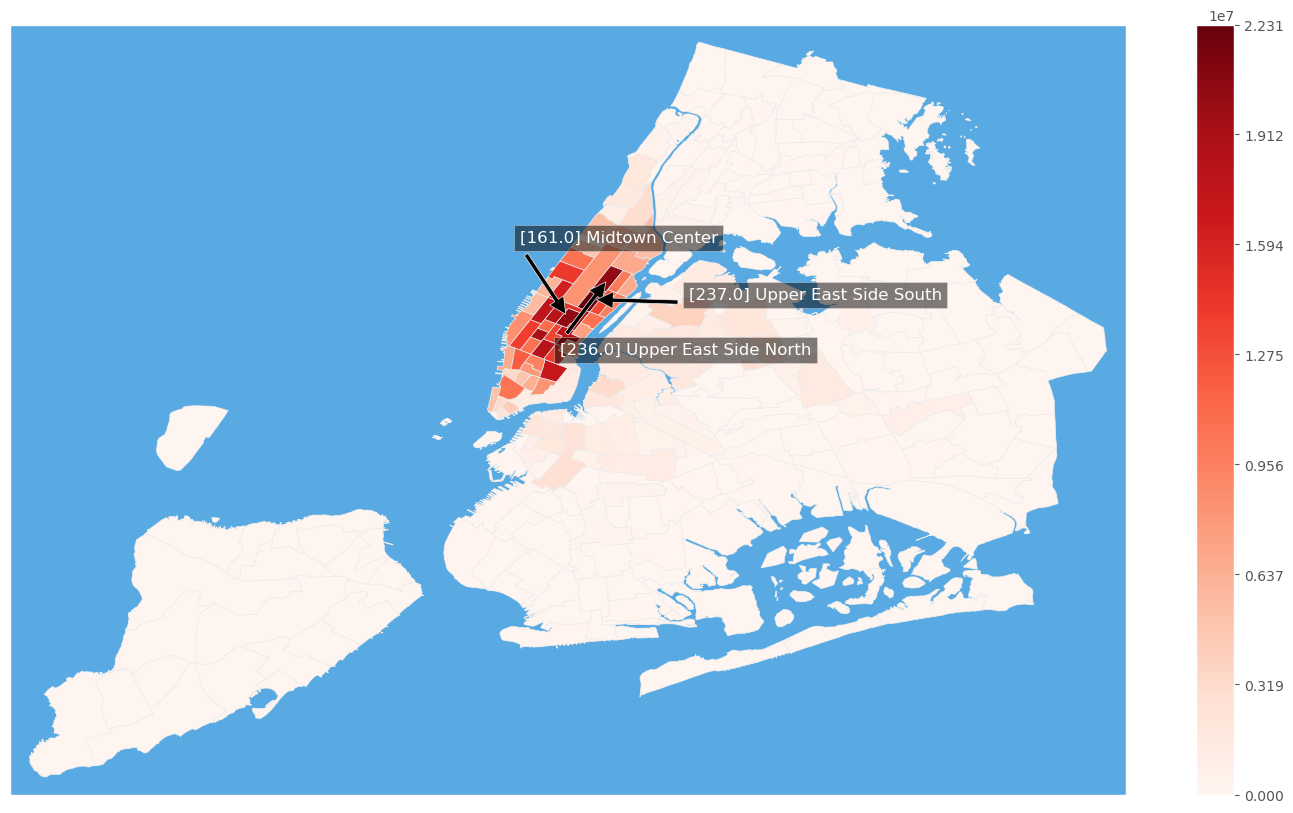

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
draw_zone_map(ax, sf, heat=PUcount_yellow, text=PUtop3_yellow.index.tolist())


C:\Users\max-admin\AppData\Local\Temp\ipykernel_14188\634614108.py:112: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


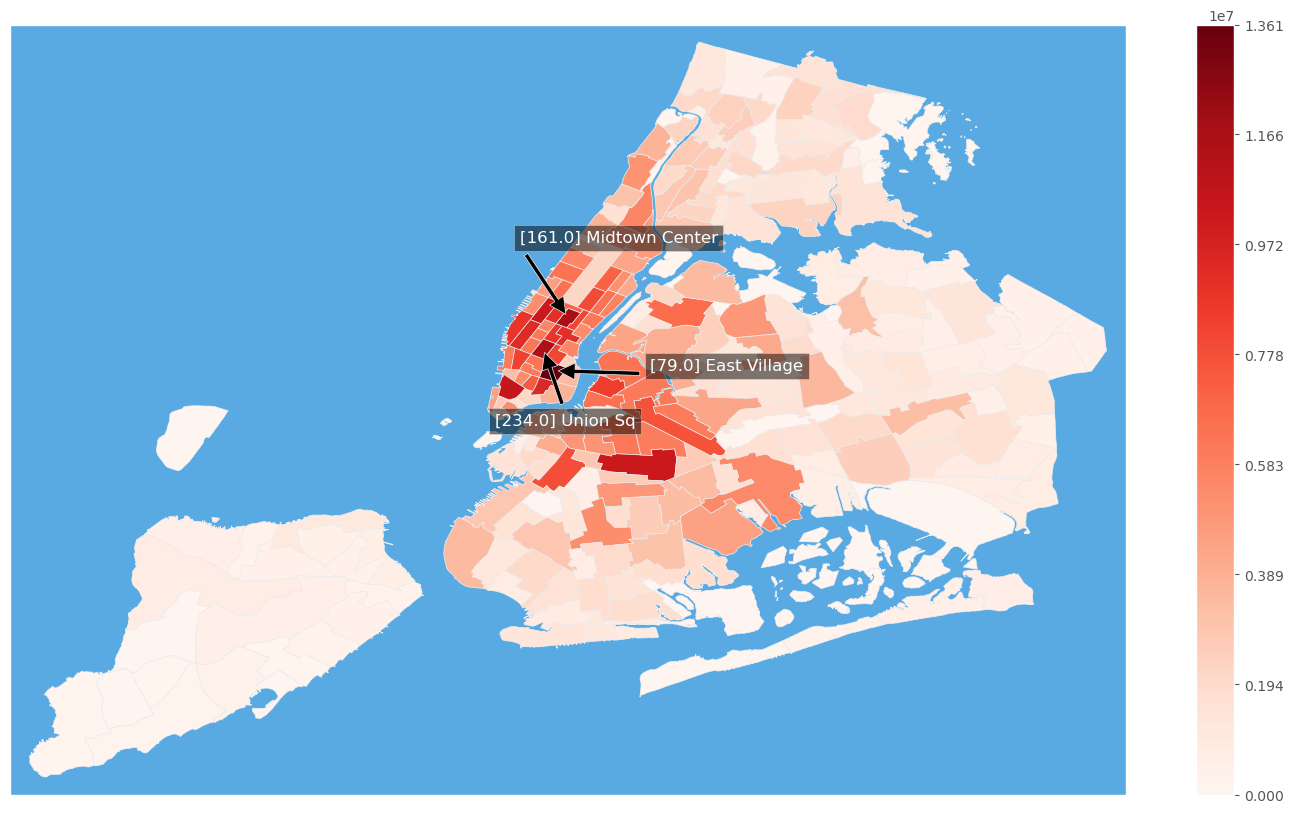

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
draw_zone_map(ax, sf, heat=PUcount_fhv, text=PUtop3_fhv.index.tolist())

##### 3. Chebyshev Polynomial Plots and Log-Transformation

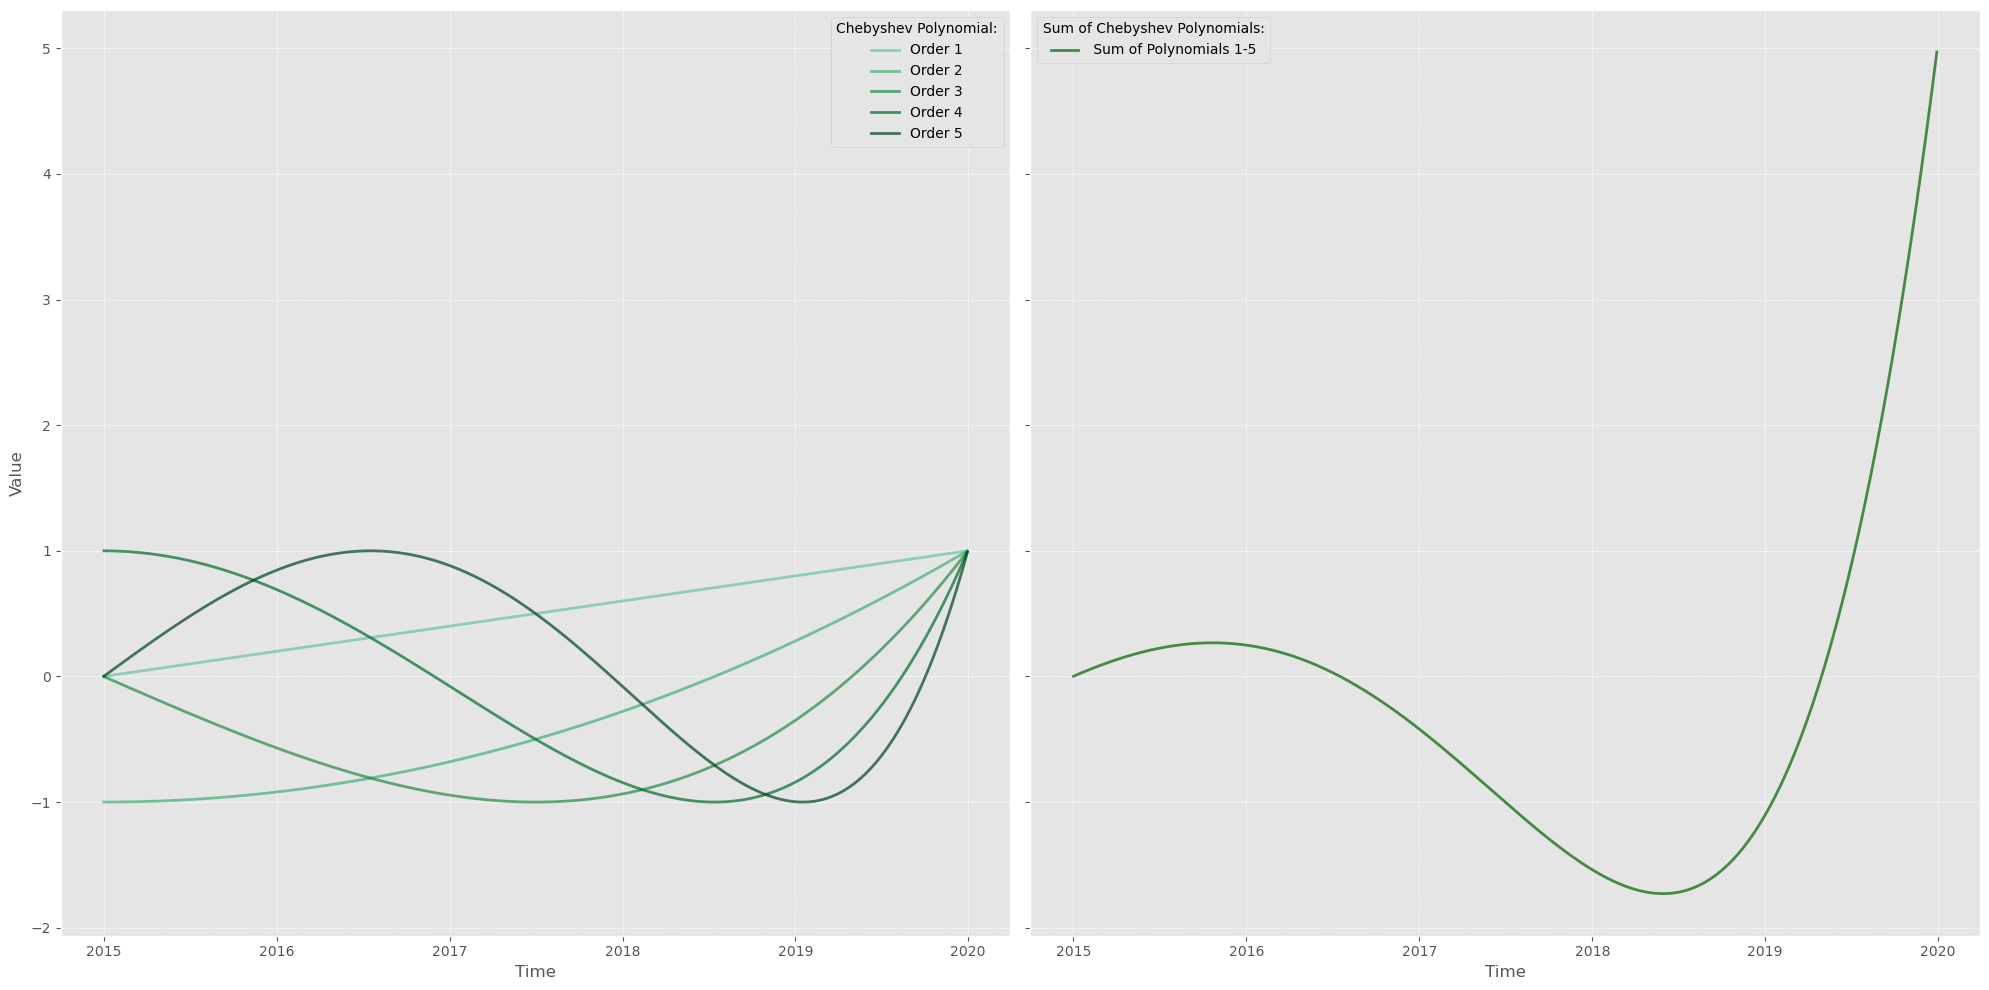

In [14]:
taxi_data_cut = fhv.copy()

# Ensure 'date_pickup' is in datetime format
taxi_data_cut['date_pickup'] = pd.to_datetime(taxi_data_cut['date_pickup'])

# Calculate the sum of cheby_1 to cheby_5 for each row
taxi_data_cut['sum_cheby'] = taxi_data_cut[['cheby_1', 'cheby_2', 'cheby_3', 'cheby_4', 'cheby_5']].sum(axis=1)

# Creating a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
cheby_orders = ['Order 1', 'Order 2', 'Order 3', 'Order 4', 'Order 5']
colors = ['#66c2a5', '#41ae76', '#238b45', '#006d2c', '#00441b']


# Plotting individual cheby columns on the first subplot
for i, order in enumerate(cheby_orders, start=1):
    axs[0].plot(taxi_data_cut['date_pickup'], taxi_data_cut[f'cheby_{i}'], linestyle='-', linewidth=2, alpha=0.7, label=order, color=colors[i-1])

axs[0].xaxis.set_major_locator(mdates.YearLocator())
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].legend(title='Chebyshev Polynomial:', fontsize=10)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plotting the sum of cheby_1 to cheby_5 on the second subplot
axs[1].plot(taxi_data_cut['date_pickup'], taxi_data_cut['sum_cheby'], linestyle='-', linewidth=2, alpha=0.7, label=' Sum of Polynomials 1-5', color='darkgreen')

axs[1].xaxis.set_major_locator(mdates.YearLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1].set_xlabel('Time')
axs[1].legend(title='Sum of Chebyshev Polynomials:', fontsize=10)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

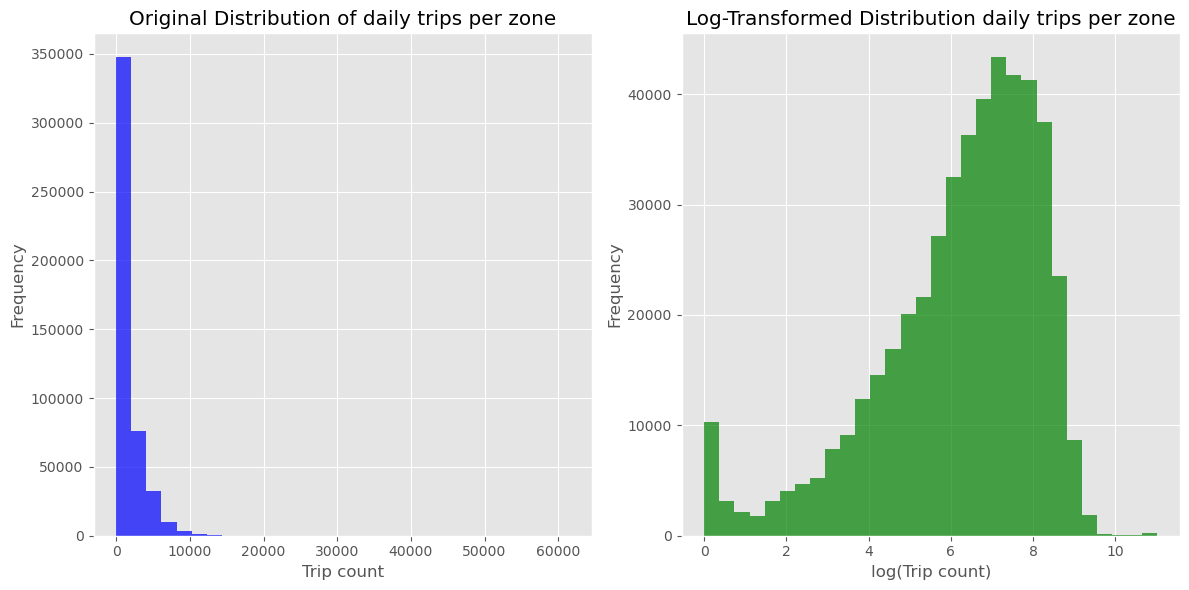

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
# Plotting the distribution of the non-transformed variable
plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
plt.hist(taxi_data_cut['trip_number'], bins=30, color='blue', alpha=0.7)
plt.title('Original Distribution of daily trips per zone')
plt.xlabel('Trip count')
plt.ylabel('Frequency')

# Log-transformed distribution
plt.subplot(1, 2, 2)
plt.hist(taxi_data_cut['log_total'], bins=30, color='green', alpha=0.7)
plt.title('Log-Transformed Distribution daily trips per zone')
plt.xlabel('log(Trip count)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

taxi_data_cut['log_total'] = np.log(taxi_data_cut['trip_number'])

In [23]:
taxi_data = taxi_data_cut.copy()

In [24]:
# add chebyshev_polynomials- time trends
num_days = len(taxi_data["date_pickup"].unique())

taxi_data['cheby_0'] = 1
taxi_data['cheby_1'] = taxi_data['date_pickup'].rank(method='dense').astype(int)/num_days


# recursively defining other chebyshev polynomials for each day until 5th order
for i in range(2, 6):
    taxi_data[f"cheby_{i}"] = (2  * taxi_data["cheby_1"] * taxi_data[f"cheby_{i-1}"]) - taxi_data[f"cheby_{i-2}"]